# Cell Tracking (Project 6)

**Group 12: Maximilian Karhausen, Johannes Simon**

**Background:** When testing a pharmacological drug onto cells, the effect on the cell population growth and 
overall phenotype is usually assessed by a single snapshot image. While these population and 
time-averaged measurements can highlight big scale effects between cell populations and 
conditions, they are an indirect measure of responses to chemotherapeutic drugs. Another 
approach is to record long videos of these cell populations while subjected to the drugs. These 
live observations are more accurate in capturing the proliferation behavior than standard 
approaches. Manual tracking of each single cell in the visual field is very time-consuming.

**Approach:** Given pre-detected cancer cells (in COCO format), we investigate suitable methods to match detections across frames (tracking). To do this, we compare the tracking methods SORT and DeepSORT with each other.

In [2]:
# Get all necessary imports
import json
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import random

## Part 1: Load the dataset and classify the cells

In [5]:
# Initialize local paths
# Dataset path
# Hint: (change to "/scratch/cv-course/jsimon10/dataset_jpg/dataset" when working on RAMSES)
ROOT_DIR = Path("dataset_jpg/dataset")
# Annotations file path
ANN_FILE = ROOT_DIR / "annotations.json"
# Create folder for cropped cells, needed later to train appearance model for DeepSORT
CROP_DIR = Path("cell_crops")
CROP_DIR.mkdir(exist_ok=True)

In [7]:
# Load the COCO annotations from the annotations.json file
with ANN_FILE.open("r") as f:
    coco = json.load(f)
# Get category name by their ID
cat_name_by_id = {cat["id"]: cat["name"] for cat in coco["categories"]}
# Group all annotations by their image ID to find all cells for each image more easily
annots_by_img = {}
for ann in coco["annotations"]:
    annots_by_img.setdefault(ann["image_id"], []).append(ann)
# Group all images by their ID to find them more faster
img_by_id = {}
for img in coco["images"]:
    img_by_id[img["id"]] = img
# Print summary info on the dataset once loaded
print("Loaded dataset with:")
print(f"  - {len(coco['images'])} images")
print(f"  - {len(coco['annotations'])} annotations")
print(f"  - {len(coco['categories'])} categories:")
for cat_id, cat_name in cat_name_by_id.items():
    print(f"    ID {cat_id}: {cat_name}")

Loaded dataset with:
  - 40350 images
  - 2204912 annotations
  - 2 categories:
    ID 1: living_cell
    ID 2: dead_cell


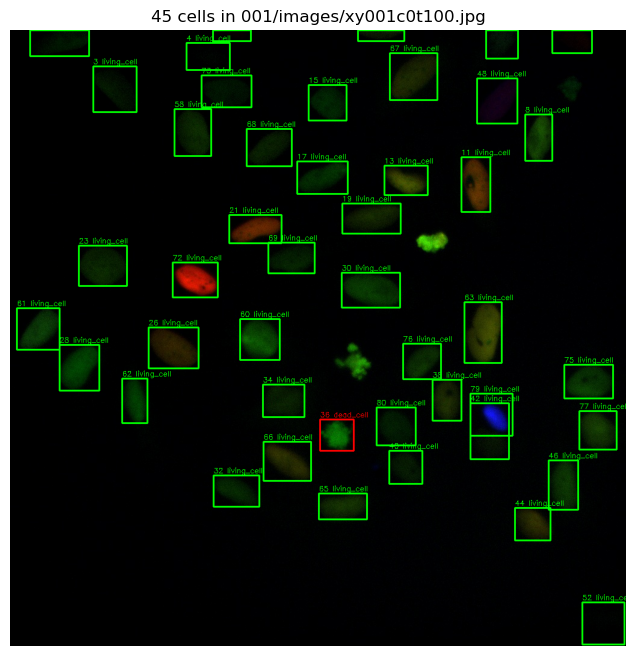

In [9]:
# Get an image by an selected index for visualization
img_example = img_by_id[100] # For testing, only index of 0-449 works. Original dataset: up to 40349
# Get the path to the image
img_path = ROOT_DIR / img_example["file_name"]
# Raise an error if image does not exist
if not img_path.exists():
    raise FileNotFoundError(f"Image file not found: {img_path}")
# Load the image and turn from BGR to RGB
img_rgb = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
# Get annotations for the selected image
annots = annots_by_img.get(img_example["id"], [])
# Apply different colors for bounding boxes of different classes
bbox_color_map = {
    "living_cell": (0, 255, 0),     # green for living cell
    "dead_cell": (255, 0, 0),     # red for dead cell
}
# Draw bounding boxes based on annotations
for i, ann in enumerate(annots):
    # Get center x and y coordinates of the bounding box with width and height
    x_center, y_center, width, height = ann["bbox"]
    # For correct drawing (and SORT later), convert center-based x and y coordinates to top-left
    x, y = x_center - width / 2, y_center - height / 2
    # For correct drawing, turn float values to int values - OpenCV expects int values
    x_draw, y_draw, width_draw, height_draw = int(x), int(y), int(width), int(height)
    # Get the classified category
    cat_id = ann["category_id"]
    # Get the respective category name
    cat_name = cat_name_by_id.get(cat_id, "unknown") # Edge case: If annotation without category exist, label as "unknown"
    # Construct label with cell ID and category name, e.g. 30 living_cell
    label = f"{ann['cell_id']} {cat_name}"
    # Get the respective color of bounding box
    color = bbox_color_map.get(cat_name, (255, 255, 255)) # Edge case: If annotation without category exist, color white
    # Draw the bounding boxes and the text with the classified category 
    cv2.rectangle(img_rgb, (x_draw, y_draw), (x_draw + width_draw, y_draw + height_draw), color, 2)
    cv2.putText(img_rgb, label, (x_draw, y_draw - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
# Show classification result
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"{len(annots)} cells in {img_example['file_name']}")
plt.show()

## Part 2: Prepare the data to train the appearance model of DeepSORT

In [13]:
test_folders = {"001", "002", "003"} # REMOVE THIS FOR ORIGINAL DATASET
# Crop cells for all annotations
for ann in coco["annotations"]:
    # Get image from current annotation
    img = img_by_id[ann["image_id"]]
    # Get image path of given image
    img_path = ROOT_DIR / img["file_name"]
    folder = Path(img["file_name"]).parts[0] # REMOVE THIS FOR ORIGINAL DATASET
    if folder not in test_folders: # REMOVE THIS FOR ORIGINAL DATASET
        continue # REMOVE THIS FOR ORIGINAL DATASET
    # Load the image in BGR format
    img_bgr = cv2.imread(str(img_path))
    # Get center x and y coordinates of the bounding box with width and height
    x_center, y_center, width, height = ann["bbox"]
    # Get image bounds of the cell
    x0, y0, x1, y1 = int(x_center - width / 2), int(y_center - height / 2), int(x_center + width / 2), int(y_center + height / 2)
    # Get actual height and width of the original image
    img_height, img_width = img_bgr.shape[:2]
    # Skip all edge-cut cells
    if (x0 <= 0 or y0 <= 0 or x1 >= img_width or y1 >= img_height):
        continue
    # Define unique ID as video ID and cell ID for folder, e.g. 001_001
    id = f"{ann['video_id']:03d}_{ann['cell_id']:03d}"
    # Get the classified category
    cat_id = ann["category_id"]
    # Get the respective category name
    cat_name = cat_name_by_id.get(cat_id, "unknown") # Edge case: If annotation without category exist, label as "unknown"
    # Create folder for given cell ID by video ID to save cropped cells
    output_dir = CROP_DIR / id
    output_dir.mkdir(parents=True, exist_ok=True)
    # Save cropped cell with annotation ID and classified category, e.g. 0000002_living_cell.jpg
    output_img_name = f"{ann['id']:07d}_{cat_name}.jpg"
    # Specify path of cropped cell image
    output_img_path = output_dir / output_img_name
    # Crop the original image to constructed bounding box with the cell and write it to given path
    cv2.imwrite(str(output_img_path), img_bgr[y0:y1, x0:x1])
print("Successfully cropped cells for training the appearance model of DeepSORT")

Successfully cropped cells for training the appearance model of DeepSORT


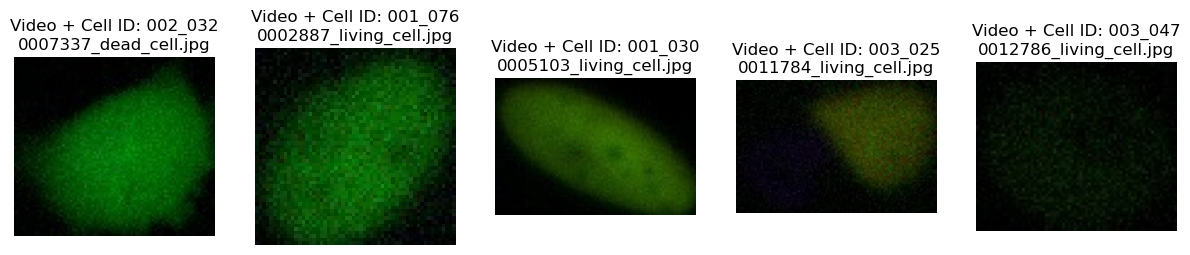

In [25]:
# Collect all cropped cell image paths
crop_paths = list(CROP_DIR.rglob("*.jpg"))
# Randomly pick five example images
crop_examples = random.sample(crop_paths, 5)
# Plot the five images
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(crop_examples):
    # Load the current image
    img = cv2.imread(str(img_path))
    # Turn the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Create five consecutive subplots
    plt.subplot(1, 5, i+1)
    plt.imshow(img_rgb)
    # Print folder and image name
    plt.title("Video + Cell ID: " + img_path.parts[-2] + "\n" + img_path.name)
    plt.axis('off')
plt.show()

In [31]:
# Initialize path of folder with the cropped cells
crop_dir = Path("cell_crops")
# Get a sorted list of all cropped cells in the folder
all_cells = sorted([cell_dir for cell_dir in crop_dir.iterdir() if cell_dir.is_dir()])
# Create the train and test folders
train_dir = crop_dir / "train"
test_dir = crop_dir / "test"
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)
# Shuffle and split the cropped cells into train (70%) and test (30%) folders
random.seed(30)
random.shuffle(all_cells)
split_idx = int(len(all_cells) * 0.7)
train_cells = all_cells[:split_idx]
test_cells = all_cells[split_idx:]
# Move the cropped cells to their respective train or test folder
for cell_dir in train_cells:
    cell_dir.rename(train_dir / cell_dir.name)
for cell_dir in test_cells:
    cell_dir.rename(test_dir / cell_dir.name)